In [1]:
import pandas as pd
import os
import xgboost as xgb
#import lightgbm
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import lightgbm
pd.options.mode.chained_assignment = None

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
os.chdir('../..')
DATA_PATH = 'data/processed/'

In [3]:
full_data = pd.read_pickle(DATA_PATH + 'gameweek_data.pkl')
print(full_data.shape)
full_data.head()

(67910, 64)


,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,9,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,13,0,0,0,0.0,526,0.0,0,2016-08-20T16:30:00Z,20 Aug 17:30,0,0,0,0,0,8,0,0,0,0,0,0,2,0,7400,0,0,0,0,0,0.0,0,-578,153,731,50,False,0,0,2,2016-17,1,0,0,1,0
2,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,28,0,0,0,0.0,1066,0.0,0,2016-08-27T14:00:00Z,27 Aug 15:00,0,0,0,0,0,18,0,0,0,0,0,0,3,0,7708,0,0,0,3,1,0.0,0,-571,150,721,50,False,0,0,3,2016-17,1,1,0,0,0
3,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,31,0,0,0,0.0,1616,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,13,0,0,0,0,0,0,4,0,8072,0,0,0,1,2,0.0,0,-449,183,632,49,True,0,0,4,2016-17,1,1,0,0,0
4,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,43,0,0,0,0.0,2197,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,7,0,0,0,0,0,0,5,0,8379,0,0,0,4,1,0.0,0,-158,172,330,49,False,0,0,5,2016-17,1,1,0,0,0


In [4]:
full_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

In [5]:
# Use 16/17 and 17/18 as training data and 18/19 as test
training_data = full_data.copy()[full_data['season'] != '2018-19'].reset_index(drop=True)
test_data = full_data.copy()[full_data['season'] == '2018-19'].reset_index(drop=True)

In [6]:
training_data.sort_values(by=['clean_name','season_num','gw'], inplace=True)
training_data.reset_index(drop=True, inplace=True)

In [7]:
training_data.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15T19:00:00Z,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,2016-17,1,0,0,0,0
1,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21T15:00:00Z,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,2016-17,1,0,0,0,0
2,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28T15:00:00Z,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,2016-17,1,0,0,0,0
3,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,2016-17,1,0,0,0,0
4,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,2016-17,1,0,0,0,0


In [8]:
# Create unique ID for each player, position, season combination

id_df = training_data.groupby(['clean_name', 'pos', 'season']).count().reset_index()[['clean_name', 'pos', 'season']]
id_df['ID'] = id_df.index + 1
id_df.head()

,clean_name,pos,season,ID
0,Aaron_Cresswell,DEF,2016-17,1
1,Aaron_Cresswell,DEF,2017-18,2
2,Aaron_Lennon,MID,2016-17,3
3,Aaron_Lennon,MID,2017-18,4
4,Aaron_Mooy,MID,2017-18,5


In [9]:
training_data = training_data.merge(id_df, how='left', on=['clean_name', 'pos', 'season'])

In [10]:
def preprocess_data(df):
    df.drop(['pos', 'name', 'element', 'id', 'kickoff_time', 'kickoff_time_formatted', 'season', 'season_num', 'clean_name', 'fixture', 'opponent_team', 'round'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [11]:
preprocess_data(training_data)
training_data.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,0,0,0,0,1


### Baseline

In [12]:
mean_points_by_player = training_data.groupby(['ID']).mean()['total_points'].reset_index()
mean_points_by_player.rename(columns={'total_points': 'mean_pts_per_gw'}, inplace=True)
mean_points_by_player.head()

,ID,mean_pts_per_gw
0,1,1.578947
1,2,3.105263
2,3,0.578947
3,4,1.710526
4,5,2.973684


In [13]:
# Get player info corresponding to ID
mean_points_by_player = mean_points_by_player.merge(id_df, how='left', on='ID')
mean_points_by_player.head()

,ID,mean_pts_per_gw,clean_name,pos,season
0,1,1.578947,Aaron_Cresswell,DEF,2016-17
1,2,3.105263,Aaron_Cresswell,DEF,2017-18
2,3,0.578947,Aaron_Lennon,MID,2016-17
3,4,1.710526,Aaron_Lennon,MID,2017-18
4,5,2.973684,Aaron_Mooy,MID,2017-18


In [14]:
# Take mean over all season data for a given player
mean_points_by_player = mean_points_by_player.groupby('clean_name').mean().reset_index()[['clean_name', 'mean_pts_per_gw']]

In [15]:
baseline_data = test_data.merge(mean_points_by_player, how='left', on='clean_name')

In [16]:
# For new players in 18/19 season use mean of previous season scores:
baseline_data['mean_pts_per_gw'].fillna(baseline_data['mean_pts_per_gw'].mean(), inplace=True)

In [17]:
baseline_mse = mean_squared_error(baseline_data['total_points'], baseline_data['mean_pts_per_gw'])
baseline_mse

6.266441861639234

### Create model

In [18]:
training_data.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,0,0,0,0,1


In [19]:
training_data['ID'].nunique()

1330

In [20]:
val_pc = 0.3
number_of_unique_ids = training_data['ID'].nunique()

validation_ids = random.sample(range(1, number_of_unique_ids + 1), int(0.3 * number_of_unique_ids))
len(validation_ids)

399

In [21]:
train_new = training_data[~training_data['ID'].isin(validation_ids)]
train_new.reset_index(drop=True, inplace=True)

In [22]:
train_new.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,0,0,0,0,1


In [23]:
static_features = ['position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'ID', 'was_home']
ts_features = set(train_new.columns) - set(static_features)

In [24]:
ts_features.remove('gw')

In [52]:
# Create additional time series features:
for col in ts_features:
    
    train_new[col+'_EMA'] = train_new.groupby('ID')[col].apply(lambda x: x.ewm(halflife=4).mean())
    train_new[col+'_EMA'] = train_new.groupby('ID')[col+'_EMA'].shift(1)
    
    if col == 'total_points':
        train_new[col+'_AR1'] = train_new.groupby('ID')[col].shift(1)
        train_new[col+'_AR2'] = train_new.groupby('ID')[col].shift(2)
        
    else:
        train_new[col+'_L1'] = train_new.groupby('ID')[col].shift(1)
        train_new[col+'_L2'] = train_new.groupby('ID')[col].shift(2)
        train_new.drop(col, axis=1, inplace=True)

In [53]:
train_new.head()

,total_points,was_home,gw,position_DEF,position_FWD,position_GK,position_MID,ID,key_passes_EMA,key_passes_L1,key_passes_L2,team_h_score_EMA,team_h_score_L1,team_h_score_L2,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,target_missed_EMA,target_missed_L1,target_missed_L2,value_EMA,value_L1,value_L2,winning_goals_EMA,winning_goals_L1,winning_goals_L2,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,fouls_EMA,fouls_L1,fouls_L2,ea_index_EMA,ea_index_L1,ea_index_L2,influence_EMA,influence_L1,influence_L2,penalties_conceded_EMA,penalties_conceded_L1,penalties_conceded_L2,red_cards_EMA,red_cards_L1,red_cards_L2,selected_EMA,selected_L1,selected_L2,tackled_EMA,tackled_L1,tackled_L2,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,big_chances_created_EMA,big_chances_created_L1,big_chances_created_L2,transfers_out_EMA,transfers_out_L1,transfers_out_L2,loaned_in_EMA,loaned_in_L1,loaned_in_L2,total_points_EMA,total_points_AR1,total_points_AR2,dribbles_EMA,dribbles_L1,dribbles_L2,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,team_a_score_EMA,team_a_score_L1,team_a_score_L2,bps_EMA,bps_L1,bps_L2,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,recoveries_EMA,recoveries_L1,recoveries_L2,assists_EMA,assists_L1,assists_L2,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,creativity_EMA,creativity_L1,creativity_L2,offside_EMA,offside_L1,offside_L2,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,errors_leading_to_goal_EMA,errors_leading_to_goal_L1,errors_leading_to_goal_L2,transfers_in_EMA,transfers_in_L1,transfers_in_L2,ict_index_EMA,ict_index_L1,ict_index_L2,threat_EMA,threat_L1,threat_L2,tackles_EMA,tackles_L1,tackles_L2,attempted_passes_EMA,attempted_passes_L1,attempted_passes_L2,bonus_EMA,bonus_L1,bonus_L2,saves_EMA,saves_L1,saves_L2,completed_passes_EMA,completed_passes_L1,completed_passes_L2,own_goals_EMA,own_goals_L1,own_goals_L2,goals_scored_EMA,goals_scored_L1,goals_scored_L2,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,open_play_crosses_EMA,open_play_crosses_L1,open_play_crosses_L2,minutes_EMA,minutes_L1,minutes_L2,loaned_out_EMA,loaned_out_L1,loaned_out_L2
0,0,False,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,2,0,0,0,0,1,0.0,0.0,NaN,2.000000,2.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,55.000000,55.0,NaN,0.0,0.0,NaN,0.000000,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,14023.000000,14023.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.000000,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.000000,1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.000000,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2,0,False,3,0,0,0,0,1,0.0,0.0,0.0,1.456786,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,55.000000,55.0,55.0,0.0,0.0,0.0,-1630.727278,-3002.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12669.311667,11531.0,14023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1673.641154,3081.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.913876,79.0,0.0,0.0,0.0,0

In [54]:
train_new.dropna(axis=0, inplace=True)

In [55]:
xgb_model = xgb.XGBRegressor()

In [56]:
xgb_model.fit(train_new.drop(['ID', 'total_points'], axis=1), train_new['total_points'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [57]:
predictions_train = xgb_model.predict(train_new.drop(['ID', 'total_points'], axis=1))

In [58]:
mean_squared_error(train_new['total_points'], predictions_train)

4.313330908410589

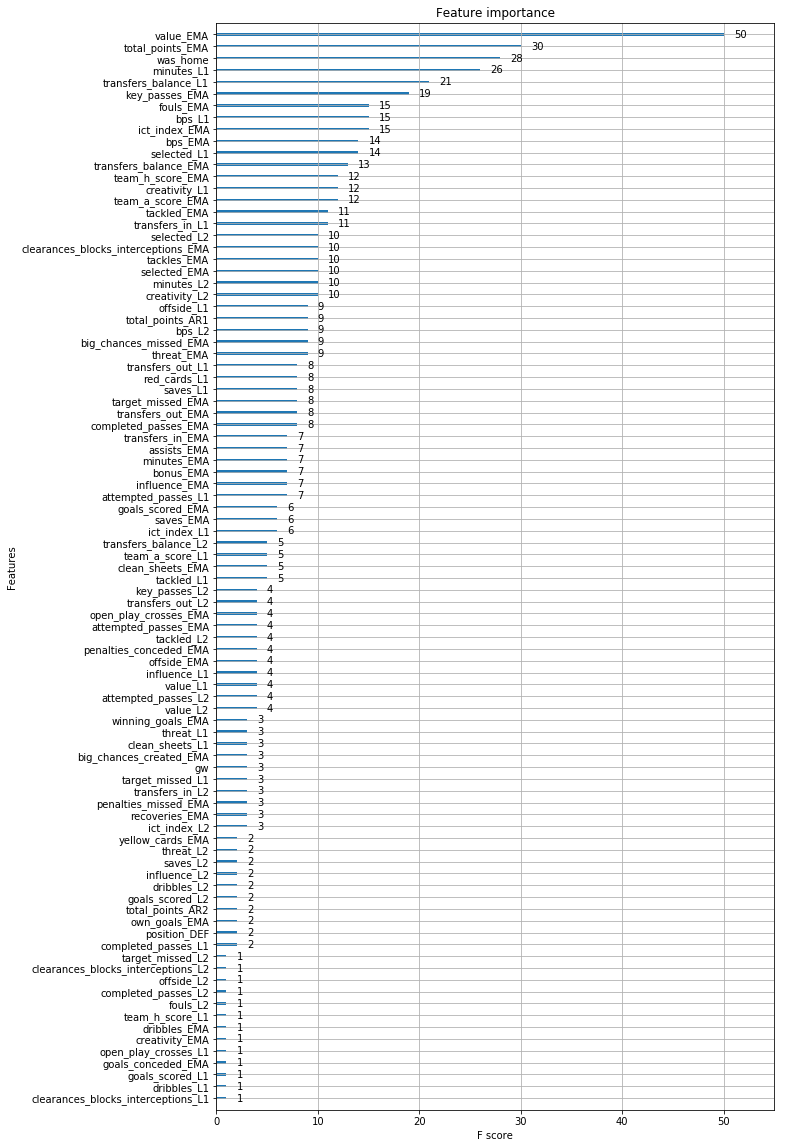

In [59]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(xgb_model, ax=ax)

In [25]:
class TimeSeriesFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, halflife, max_lag, max_diff, columns):
        
        self.halflife = halflife
        self.max_lag = max_lag
        self.max_diff = max_diff
        self.columns = columns

    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        features = self.X.copy()
        for col in self.columns:
            # EWM
            features[col+'_EMA'] = features.groupby('ID')[col].apply(lambda x: x.ewm(halflife=self.halflife).mean())
            features[col+'_EMA'] = features.groupby('ID')[col+'_EMA'].shift(1)  # Shift to prevent use of current GW features

            # Lagged variables
            for lag in range(1, self.max_lag + 1):
                features[col + f'_L{lag}'] = features.groupby('ID')[col].shift(lag) 

            # Difference variables
            for diff in range(1, self.max_diff + 1):
                features[col + f'_D{diff}'] = features.groupby('ID')[col].shift(1).diff(diff)  # Shift to prevent use of current GW features

            # Drop current GW features
            if col != 'total_points':
                features.drop(col, axis=1, inplace=True)
            else:
                continue
        
        features.drop(columns=['ID', 'total_points'], axis=1, inplace=True)

        return features

In [26]:
train_new.shape

(32427, 53)

In [119]:
ts_test = TimeSeriesFeatures(halflife=4, max_lag=1, max_diff=2, columns=ts_features)

In [85]:
df_test = ts_test.fit_transform(train_new)

In [86]:
df_test.shape

(32311, 190)

In [58]:
df_test.head()

,total_points,was_home,gw,position_DEF,position_FWD,position_GK,position_MID,ID,loaned_out_EMA,loaned_out_L1,loaned_out_D1,loaned_out_D2,winning_goals_EMA,winning_goals_L1,winning_goals_D1,winning_goals_D2,goals_scored_EMA,goals_scored_L1,goals_scored_D1,goals_scored_D2,dribbles_EMA,dribbles_L1,dribbles_D1,dribbles_D2,loaned_in_EMA,loaned_in_L1,loaned_in_D1,loaned_in_D2,clean_sheets_EMA,clean_sheets_L1,clean_sheets_D1,clean_sheets_D2,team_a_score_EMA,team_a_score_L1,team_a_score_D1,team_a_score_D2,bps_EMA,bps_L1,bps_D1,bps_D2,yellow_cards_EMA,yellow_cards_L1,yellow_cards_D1,yellow_cards_D2,influence_EMA,influence_L1,influence_D1,influence_D2,transfers_in_EMA,transfers_in_L1,transfers_in_D1,transfers_in_D2,open_play_crosses_EMA,open_play_crosses_L1,open_play_crosses_D1,open_play_crosses_D2,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,red_cards_EMA,red_cards_L1,red_cards_D1,red_cards_D2,bonus_EMA,bonus_L1,bonus_D1,bonus_D2,creativity_EMA,creativity_L1,creativity_D1,creativity_D2,ict_index_EMA,ict_index_L1,ict_index_D1,ict_index_D2,own_goals_EMA,own_goals_L1,own_goals_D1,own_goals_D2,goals_conceded_EMA,goals_conceded_L1,goals_conceded_D1,goals_conceded_D2,assists_EMA,assists_L1,assists_D1,assists_D2,recoveries_EMA,recoveries_L1,recoveries_D1,recoveries_D2,target_missed_EMA,target_missed_L1,target_missed_D1,target_missed_D2,transfers_balance_EMA,transfers_balance_L1,transfers_balance_D1,transfers_balance_D2,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,completed_passes_EMA,completed_passes_L1,completed_passes_D1,completed_passes_D2,selected_EMA,selected_L1,selected_D1,selected_D2,penalties_conceded_EMA,penalties_conceded_L1,penalties_conceded_D1,penalties_conceded_D2,tackles_EMA,tackles_L1,tackles_D1,tackles_D2,penalties_missed_EMA,penalties_missed_L1,penalties_missed_D1,penalties_missed_D2,key_passes_EMA,key_passes_L1,key_passes_D1,key_passes_D2,transfers_out_EMA,transfers_out_L1,transfers_out_D1,transfers_out_D2,ea_index_EMA,ea_index_L1,ea_index_D1,ea_index_D2,fouls_EMA,fouls_L1,fouls_D1,fouls_D2,penalties_saved_EMA,penalties_saved_L1,penalties_saved_D1,penalties_saved_D2,saves_EMA,saves_L1,saves_D1,saves_D2,errors_leading_to_goal_EMA,errors_leading_to_goal_L1,errors_leading_to_goal_D1,errors_leading_to_goal_D2,total_points_EMA,total_points_L1,total_points_D1,total_points_D2,big_chances_created_EMA,big_chances_created_L1,big_chances_created_D1,big_chances_created_D2,offside_EMA,offside_L1,offside_D1,offside_D2,team_h_score_EMA,team_h_score_L1,team_h_score_D1,team_h_score_D2,threat_EMA,threat_L1,threat_D1,threat_D2,tackled_EMA,tackled_L1,tackled_D1,tackled_D2,attempted_passes_EMA,attempted_passes_L1,attempted_passes_D1,attempted_passes_D2,value_EMA,value_L1,value_D1,value_D2,minutes_EMA,minutes_L1,minutes_D1,minutes_D2,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_D1,big_chances_missed_D2
3,0,True,4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669978,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.060714,28.0,-51.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1796.454198,-2053.0,949.0,-2053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11459.614728,9587.0,-1944.0,-4436.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1833.514912,2081.0,-1000.0,2081.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.062442,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.607536,54.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,False,5,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [88]:
pipe = Pipeline(
    steps=[
        ('time_series_features', ts_test),
        ('model', xgb.XGBRegressor())
    ]
)

In [89]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'time_series_features', 'model', 'time_series_features__columns', 'time_series_features__halflife', 'time_series_features__max_diff', 'time_series_features__max_lag', 'model__base_score', 'model__booster', 'model__colsample_bylevel', 'model__colsample_bytree', 'model__gamma', 'model__learning_rate', 'model__max_delta_step', 'model__max_depth', 'model__min_child_weight', 'model__missing', 'model__n_estimators', 'model__n_jobs', 'model__nthread', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__scale_pos_weight', 'model__seed', 'model__silent', 'model__subsample'])

In [48]:
params = {
    'time_series_features__halflife': list(range(3, 7)),
    'time_series_features__max_diff': list(range(1, 5)),
    'time_series_features__max_lag': list(range(1, 5)),
          }

In [49]:
param_dict = []
mse_scores = []

start = datetime.datetime.now()

total_combinations = len(params['time_series_features__halflife']) * len(params['time_series_features__max_diff']) * len(params['time_series_features__max_lag'])
print(f'Total combinations: {total_combinations}')

for hl in params['time_series_features__halflife']:
    for diff in params['time_series_features__max_diff']:
        for lag in params['time_series_features__max_lag']:

            print(f'Working on halflife: {hl}, max_diff: {diff}, max_lag: {lag}... \n')
            
            model_params = {
                'time_series_features__halflife': hl,
                'time_series_features__max_diff': diff,
                'time_series_features__max_lag': lag
            }
            

            ts_gen = TimeSeriesFeatures(halflife=hl, max_lag=lag, max_diff=diff, columns=ts_features)
            new_df = ts_gen.fit_transform(train_new)

            xgb_model = xgb.XGBRegressor()
            xgb_model.fit(new_df, train_new['total_points'])

            predictions_train = xgb_model.predict(new_df)
            mse = mean_squared_error(train_new['total_points'], predictions_train)
            
            param_dict.append(model_params)
            mse_scores.append(mse)
            
            print(f'MSE: {mse} \n')
            print(f'Finished iteration!')

end = datetime.datetime.now()

print(f'Duration {end-start}')

Total combinations: 64
Working on halflife: 3, max_diff: 1, max_lag: 1... 

MSE: 4.0756120719313005 

Finished iteration!
Working on halflife: 3, max_diff: 1, max_lag: 2... 

MSE: 4.082589299202447 

Finished iteration!
Working on halflife: 3, max_diff: 1, max_lag: 3... 

MSE: 4.061093588138079 

Finished iteration!
Working on halflife: 3, max_diff: 1, max_lag: 4... 

MSE: 4.062177965032313 

Finished iteration!
Working on halflife: 3, max_diff: 2, max_lag: 1... 

MSE: 4.072710527875348 

Finished iteration!
Working on halflife: 3, max_diff: 2, max_lag: 2... 

MSE: 4.0676978859881086 

Finished iteration!
Working on halflife: 3, max_diff: 2, max_lag: 3... 

MSE: 4.064874866117394 

Finished iteration!
Working on halflife: 3, max_diff: 2, max_lag: 4... 

MSE: 4.053539381215565 

Finished iteration!
Working on halflife: 3, max_diff: 3, max_lag: 1... 

MSE: 4.054606929149451 

Finished iteration!
Working on halflife: 3, max_diff: 3, max_lag: 2... 

MSE: 4.050810476478249 

Finished iterat

In [51]:
min_index = mse_scores.index(min(mse_scores))
min_index

47

In [52]:
param_dict[min_index]

{'time_series_features__halflife': 5,
 'time_series_features__max_diff': 4,
 'time_series_features__max_lag': 4}

Picked maximimum possible max_diff and max_lag - may be worth trying more of these (although this is only on predicted)

### Compare XGBoost with LightGBM

In [31]:
pipe = Pipeline(
    steps=[
        ('time_series_features', TimeSeriesFeatures(halflife=5, max_lag=4, max_diff=4, columns=ts_features)),
        ('model', xgb.XGBRegressor())
    ]
)

In [29]:
train_new.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,0,0,0,0,1


In [44]:
%%time
ts_gen = TimeSeriesFeatures(halflife=5, max_lag=4, max_diff=4, columns=ts_features)
new_df = ts_gen.fit_transform(train_new)

CPU times: user 1min 52s, sys: 50.7 s, total: 2min 43s
Wall time: 1min 50s


In [45]:
%%time
xgb_model = xgb.XGBRegressor()
xgb_model.fit(new_df, train_new['total_points'])

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:12:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 36s, sys: 4.02 s, total: 3min 40s
Wall time: 3min 51s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [46]:
%%time
lgbm_model = lightgbm.LGBMRegressor()
lgbm_model.fit(new_df, train_new['total_points'])

CPU times: user 27.2 s, sys: 1.23 s, total: 28.4 s
Wall time: 9.56 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
lgbm_pred = lgbm_model.predict(new_df)

In [49]:
mean_squared_error(train_new['total_points'], lgbm_pred)

2.9358372055550275

In [50]:
xgb_pred = xgb_model.predict(new_df)

In [51]:
mean_squared_error(train_new['total_points'], xgb_pred)

4.115259681582278

In [53]:
import shap

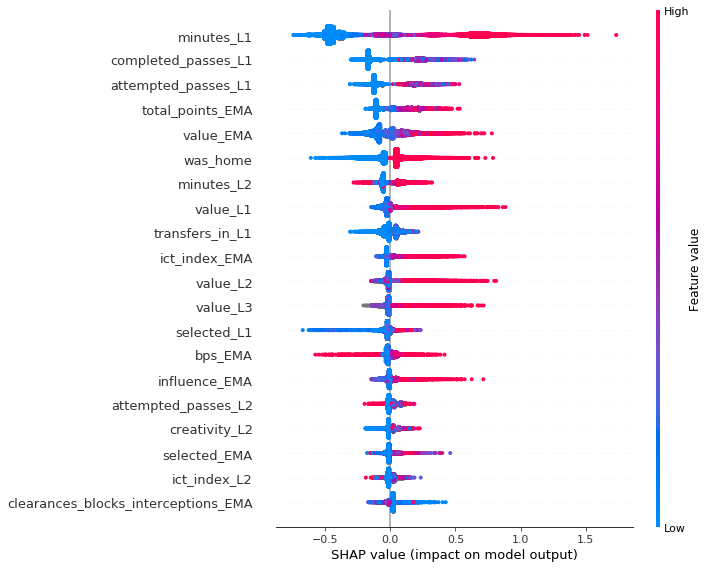

In [58]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(new_df)
shap.summary_plot(shap_values, new_df)

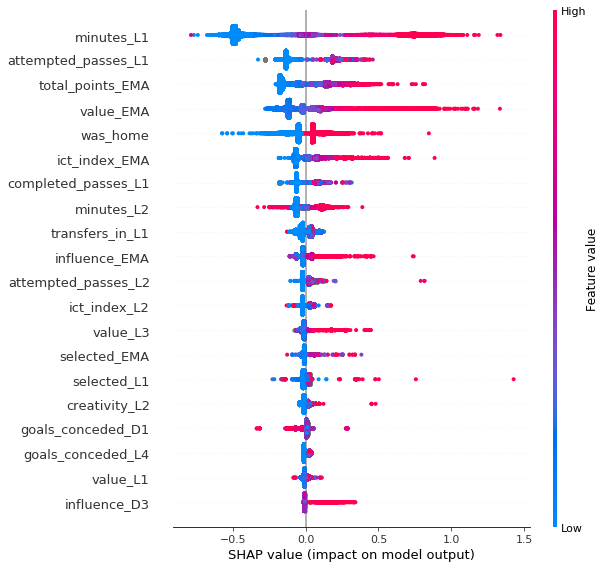

In [57]:
# XGBoost shap
shap_values_xgb = shap.TreeExplainer(xgb_model).shap_values(new_df)
shap.summary_plot(shap_values_xgb, new_df)

In [98]:
train_new_with_predictions = train_new.copy()
train_new_with_predictions['lgbm_predictions'] = lgbm_pred

In [99]:
train_new_with_predictions.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID,lgbm_predictions
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,0,0,0,0,1,1.465007
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,0,0,0,0,1,0.439279
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,0,0,0,0,1,0.186323
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,0,0,0,0,1,0.100340
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,0,0,0,0,1,0.116722


In [100]:
id_df.head()

,clean_name,pos,season,ID
0,Aaron_Cresswell,DEF,2016-17,1
1,Aaron_Cresswell,DEF,2017-18,2
2,Aaron_Lennon,MID,2016-17,3
3,Aaron_Lennon,MID,2017-18,4
4,Aaron_Mooy,MID,2017-18,5


In [101]:
train_new_with_predictions = train_new_with_predictions.merge(id_df, on='ID')

In [102]:
train_new_with_predictions = train_new_with_predictions.copy()[train_new_with_predictions['gw'] > 5]  # Get rid of GW less than 5 due to lagged terms

In [104]:
train_new_with_predictions.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,position_DEF,position_FWD,position_GK,position_MID,ID,lgbm_predictions,clean_name,pos,season
5,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7450,0,0,0,3,0,0.0,0,-500,20,520,54,True,0,0,6,0,0,0,0,1,0.101168,Aaron_Cresswell,DEF,2016-17
6,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7199,0,0,0,1,1,0.0,0,-285,40,325,53,True,0,0,7,0,0,0,0,1,0.101168,Aaron_Cresswell,DEF,2016-17
7,1,20,1,0,0,23,1,4,12,25.1,0,0,0,0,2,0,0,4.8,16.4,2,0,0,74,1,1,0,0,0,0,3,1,0,7862,0,0,1,1,0,6.0,6,468,678,210,53,False,0,0,8,0,0,0,0,1,0.111698,Aaron_Cresswell,DEF,2016-17
8,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9957,0,0,0,0,1,0.0,0,1813,2313,500,53,True,0,0,9,0,0,0,0,1,1.677521,Aaron_Cresswell,DEF,2016-17
9,0,41,0,0,0,12,0,1,35,7.9,0,0,0,0,0,2,0,1.3,5.4,0,0,0,90,0,1,0,0,0,0,3,0,0,12638,0,0,0,0,2,0.0,1,2432,2697,265,53,False,0,0,10,0,0,0,0,1,1.117583,Aaron_Cresswell,DEF,2016-17


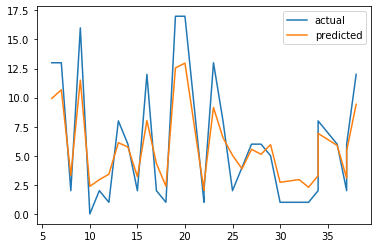

In [122]:
player_perf = train_new_with_predictions[(train_new_with_predictions['clean_name'] == 'Harry_Kane') & (train_new_with_predictions['season'] == '2017-18')]

plt.plot(player_perf['gw'], player_perf['total_points'], label='actual')
plt.plot(player_perf['gw'], player_perf['lgbm_predictions'], label='predicted')
plt.legend()